## Predicting annum average salary from  job_description using LSTM and pre-trained word embeddings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

#Model
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

#Regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(0)
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
#laod the dataset
df = pd.read_csv("data/reed_uk_clean_v3.csv")

First, we are going to pre-process our data  to prepare it for the training process.
In the next section we will carry out the following steps:
1. We will remove the top 10% of the salaries in order to remove outliers and get a better generalized in the model
2. Train-test split, we will use 20% of the data for the final test of the model
3. We will use MinMaxScaler from sklearn to scale the annum average salary to a range betewwen 0 and 1. This needs to be done to perform well in the NN training process
4. Remove stop words
5. Use keras Tokenizer to convert documents into sequences of numbers (tokens)
6. All the sequences must be the same length, so we need to calculate a max length for them. We are goin to use the mean plus 1 standard deviation of all document lengths in the training set as max length
7. Zero-pad all the word sequences to the max length defined previously 
8. Load fastText pre-trained word vectors
9. Create the embedding matrix to match the tokenized numbers generated in 5 with the wird vectors

In [4]:
#1
df = df[(df.annum_avg_salary < df.annum_avg_salary.quantile(0.90))  & (df.annum_avg_salary > 0)]

In [5]:
#2
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

Number of training data  29451
Number of testing data:  7363


In [6]:
#3
y_train = train_df[["annum_avg_salary"]]
y_scaler = MinMaxScaler(feature_range=(0,1))
y_train = y_scaler.fit_transform(y_train)

y_test = test_df["annum_avg_salary"]

In [7]:
#4
processed_docs_train = []
for document in train_df["job_description"].tolist():
    word_tokens = word_tokenize(document)
    words_clean = [each for each in word_tokens if each not in stop_words]
    processed_docs_train.append(" ".join(words_clean))

processed_docs_test = []
for document in test_df["job_description"].tolist():
    word_tokens = word_tokenize(document)
    words_clean = [each for each in word_tokens if each not in stop_words]
    processed_docs_test.append(" ".join(words_clean))

In [8]:
#5
MAX_NB_WORDS = 100000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index

In [9]:
#6
max_seq_len = int(pd.Series([len(i) for i in word_seq_train]).mean() + pd.Series([len(i) for i in word_seq_train]).std())
#max_seq_len = 280
#MAX_NB_WORDS = 100000


In [10]:
#7
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

In [12]:
#8
embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')

for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [13]:
#9
embed_dim = 300
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector

Now, we will build, compile and train the Keras model using LSTM and the Embedding layer with the weights preloaded. The summary of the model can be seen in the next cell.


In [14]:

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 282, 300)          30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 30,455,809
Trainable params: 455,809
Non-trainable params: 30,000,000
_________________________________________________________________


In [15]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [16]:
num_epochs = 12

es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.2, callbacks=[es_callback], shuffle=False)

Train on 23560 samples, validate on 5891 samples
Epoch 1/12
23560/23560 [==============================] - 41s 2ms/sample - loss: 0.0466 - mae: 0.1708 - val_loss: 0.0314 - val_mae: 0.1432
Epoch 2/12
23560/23560 [==============================] - 31s 1ms/sample - loss: 0.0296 - mae: 0.1358 - val_loss: 0.0267 - val_mae: 0.1373
Epoch 3/12
23560/23560 [==============================] - 34s 1ms/sample - loss: 0.0236 - mae: 0.1199 - val_loss: 0.0242 - val_mae: 0.1282
Epoch 4/12
23560/23560 [==============================] - 31s 1ms/sample - loss: 0.0218 - mae: 0.1144 - val_loss: 0.0252 - val_mae: 0.1295
Epoch 5/12
23560/23560 [==============================] - 31s 1ms/sample - loss: 0.0208 - mae: 0.1111 - val_loss: 0.0215 - val_mae: 0.1213
Epoch 6/12
23560/23560 [==============================] - 34s 1ms/sample - loss: 0.0202 - mae: 0.1097 - val_loss: 0.0184 - val_mae: 0.1070
Epoch 7/12
23560/23560 [==============================] - 32s 1ms/sample - loss: 0.0188 - mae: 0.1053 - val_loss: 0.0

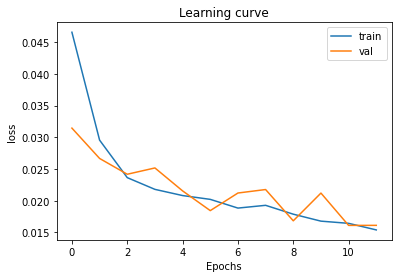

In [17]:

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning curve')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

Finally we will use the trained model to predict on unseeing data (test data) and check the performance using mae, rmse, r2 score and mape metrics

In [18]:
pred_scaled = model.predict(word_seq_test)
y_pred = y_scaler.inverse_transform(pred_scaled)

In [19]:
y_pred = y_pred.reshape(-1)
y_test_reshaped = y_test.values.reshape(-1)
r2 = r2_score(y_pred, y_test_reshaped)
mae = mean_absolute_error(y_pred, y_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_pred, y_test_reshaped))
mape = mean_absolute_percentage_error(y_pred, y_test_reshaped)
print("R2", r2)
print("MAE", mae)
print("RMSE", rmse)
print("MAPE", mape)

R2 0.33815470582537477
MAE 4915.395455720325
RMSE 6540.364552724019
MAPE 18.97577052693992


It's a decent model where in average the predictions of the salary are off by around 5,000.

We will compare our model with a base model to see if it has any predictive power. To do that we will use a dummy average model as a baseline:

In [20]:
#dummy model - using the mean as predictions
y_pred = np.full(y_test.shape[0], y_test.mean())
y_test1 = y_test.values.reshape(-1)
r2 = r2_score(y_pred, y_test1)
mae = mean_absolute_error(y_pred, y_test1)
rmse = np.sqrt(mean_squared_error(y_pred, y_test1))
mape = mean_absolute_percentage_error(y_pred, y_test1)
print("R2", r2)
print("MAE", mae)
print("RMSE", rmse)
print("MAPE", mape)

R2 -4.43129910291692e+29
MAE 8039.303965606966
RMSE 9686.919452680837
MAPE 30.1495116290873


## Conclusions

We can see that it's possible to predict the annum average salaries from job descriptions, the  built model outperforms the base model chosen. This model is far from  perfect but it is a good starting point to start iterating and getting better results. Many more things can be done to improve the model, such as:
- Taking into account more variables to train the model will surely improve its performance, variables such as category, city, state, and job type
- Make a more subtle and careful text pre-processing process
- Maybe lemmatization or stemming could work 
- Trying different pre-trained word vector such as GloVe
- Improve the network architecture
- Perform hyperparamter tunning
- Add more data

This model could be used to predict and show Torre users the approximate salary value for those offers that do not publish the values.

# Try the model

In [40]:
#write a job description and run the following cells
job_description = ' Apply now Our client, a thriving Wolverhampton manufacturing business requires a Mechanical Maintenance Engineer (Days 6.00am - 2.30pm) for a Permanent contract. It is essential you are Time-served or similarly qualified in a Mechanical discipline. The successful Mechanical Maintenance Engineer will have over 5 years Mechanical maintenance experience minimum, the ability to work unsupervised and independently, experience of maintaining equipment within a manufacturing environment, have a good work ethic and flexible approach, be time-served or similarly qualified in a Mechanical discipline, with the desirable skills of Gas cutting, welding, pneumatics and hydraulics. Responsibilities of the Mechanical Maintenance Engineer will include; process and plant support, breakdown and preventative maintenance of complex manufacturing equipment, fault finding, identification, specification and implementation equipment or areas for maintenance improvement, ensuring installation and repair duties are carried out safely and efficiently, ensuring effective communication with team, management and operatives to achieve production output and quality standards. The company offer excellent working conditions, onsite parking along with other benefits of working for a large business. Working hours are Days (6.00am - 2.30pm) Monday to Friday Â£12.00 per hour with any weekend overtime paid at Â£16.00 per hour '

In [41]:
word_tokens = word_tokenize(job_description)
words_clean = [each for each in word_tokens if each not in stop_words]
clean_doc = " ".join(words_clean)
word_seq = tokenizer.texts_to_sequences([clean_doc])
word_seq = sequence.pad_sequences(word_seq, maxlen=max_seq_len)
pred_scaled = model.predict(word_seq)
y_pred = y_scaler.inverse_transform(pred_scaled)

In [42]:
print(f"The predicted salary for the job description is {int(y_pred[0][0])}")

The predicted salary for the job description is 17125


In [ ]:
#saving the keras model
model.save('my_model.h5')